# Common functions

to be shipped to a library eventually

In [169]:
import glob
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.api.types as ptypes
from io import BytesIO

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s %(message)s'
)

def open_g1000_data(filename):
    # G1000's data isn't very clean unfortunately.
    # List of issues I've observed so far:
    #
    # - The avionics starts logging before knowing what time it is
    #   First data points will have no date and time information
    #
    # - Since there's no clean shutdown, the last line is usually broken
    #
    # - On some departure or missed approach procedures, the avionics logs
    #   the byte 0x80, which can't be decoded in ascii or utf-8
    buffer = BytesIO()
    with open(filename, 'rb') as f:
        for line in f:
            # All lines should be terminated with \n.
            # If not, it's likely the avionics was powered off.
            if not line.endswith(b'\n'):
                continue

            # Skip lines with no date and time information
            if line.startswith(b'        '):
                continue

            # Remove 0x80 bytes
            line = line.replace(b'\x80', b'')

            buffer.write(line)

    buffer.seek(0)

    # The internal time series must be converted to UTC, because on long
    # flights, the avionics may change the timezone automatically
    df = pd.read_csv(buffer, header=0, comment='#',
                     skipinitialspace=True,
                     parse_dates={'DateTime': [0, 1, 2]},
                     date_parser=lambda col: pd.to_datetime(col, utc=True),
                     low_memory=False)
    assert ptypes.is_datetime64_any_dtype(df['DateTime'])
    
    return df

def open_all_directory(directory, recursive=False, match='*.csv'):
    result = pd.DataFrame()
    flights = 0
    for f in sorted(glob.glob(directory + '/' + match, recursive=recursive)):
        logging.debug(f'Loading {f}...')
        try:
            df = open_g1000_data(f)
            
        except pd.errors.EmptyDataError:
            continue
            
        except Exception:
            print(f)
            raise

        result = result.append(df, ignore_index=True)
        flights += 1
        
    logging.debug(f'Loaded {flights} flights, with {len(result)} data points')

    return result

2020-04-28 09:53:05,036 Loaded backend module://ipykernel.pylab.backend_inline version unknown.


# Load some data

In [170]:
data = open_all_directory('/Users/mfdutra/Dropbox/dd_aviation/cirrus/data_logs', match='log_2001*.csv')

2020-04-28 09:53:22,190 Loading /Users/mfdutra/Dropbox/dd_aviation/cirrus/data_logs/log_200102_082836______.csv...
2020-04-28 09:53:22,208 Loading /Users/mfdutra/Dropbox/dd_aviation/cirrus/data_logs/log_200102_090403_KHWD.csv...
2020-04-28 09:53:23,237 Loading /Users/mfdutra/Dropbox/dd_aviation/cirrus/data_logs/log_200103_063402_KHWD.csv...
2020-04-28 09:53:23,292 Loading /Users/mfdutra/Dropbox/dd_aviation/cirrus/data_logs/log_200103_063951______.csv...
2020-04-28 09:53:23,293 Loading /Users/mfdutra/Dropbox/dd_aviation/cirrus/data_logs/log_200103_065632_KHWD.csv...
2020-04-28 09:53:23,900 Loading /Users/mfdutra/Dropbox/dd_aviation/cirrus/data_logs/log_200103_085502_KHWD.csv...
2020-04-28 09:53:23,957 Loading /Users/mfdutra/Dropbox/dd_aviation/cirrus/data_logs/log_200103_092120_KHWD.csv...
2020-04-28 09:53:25,286 Loading /Users/mfdutra/Dropbox/dd_aviation/cirrus/data_logs/log_200104_130608_KHWD.csv...
2020-04-28 09:53:25,454 Loading /Users/mfdutra/Dropbox/dd_aviation/cirrus/data_logs/lo

# Columns present in the data

In [171]:
sorted(data.columns)

['AfcsOn',
 'AltGPS',
 'AltInd',
 'AltMSL',
 'AtvWpt',
 'BaroA',
 'COM1',
 'COM2',
 'CRS',
 'DateTime',
 'E1 %Pwr',
 'E1 CHT1',
 'E1 CHT2',
 'E1 CHT3',
 'E1 CHT4',
 'E1 CHT5',
 'E1 CHT6',
 'E1 EGT1',
 'E1 EGT2',
 'E1 EGT3',
 'E1 EGT4',
 'E1 EGT5',
 'E1 EGT6',
 'E1 FFlow',
 'E1 ITT',
 'E1 MAP',
 'E1 NG',
 'E1 OilP',
 'E1 OilT',
 'E1 RPM',
 'E1 TIT1',
 'E1 TIT2',
 'E1 Torq',
 'E2 FFlow',
 'E2 ITT',
 'E2 MAP',
 'E2 NG',
 'E2 RPM',
 'E2 Torq',
 'FQtyL',
 'FQtyR',
 'GPSfix',
 'GndSpd',
 'HAL',
 'HCDI',
 'HDG',
 'HPLfd',
 'HPLwas',
 'HSIS',
 'IAS',
 'LatAc',
 'Latitude',
 'Longitude',
 'MagVar',
 'NAV1',
 'NAV2',
 'NormAc',
 'OAT',
 'PichC',
 'Pitch',
 'PitchM',
 'Roll',
 'RollC',
 'RollM',
 'TAS',
 'TRK',
 'VAL',
 'VCDI',
 'VPLwas',
 'VSpd',
 'VSpdG',
 'WndDr',
 'WndSpd',
 'WptBrg',
 'WptDst',
 'amp1',
 'volt1',
 'volt2']

# Find all takeoffs in the data

Since the Cirrus doesn't have a weight on wheels sensor, takeoffs have to be inferred in the data.

We look at all data points where IAS is between 50 and 75. When we find the first one, we look at the acceleration over the next 30 seconds (or whatever 'future' is set to). If the airplane gained at least 10 knots, this is a takeoff.

Possible false positives: slow flights and stall practices

Possible false negatives: touch and goes

In [172]:
def find_all_takeoffs(data, future=30):
    '''Return the number of detected takeoffs and
    a dataframe with all takeoff datapoints

    future: number of datapoints for each takeoff'''
    
    # Initial filter for faster processing
    indexes = data.index[(data['E1 RPM'] >= 2450) & (data['IAS'].between(50, 75))]
    if indexes.empty:
        return pd.DataFrame()
    
    takeoff_indexes = []
    skip = None
    for i in indexes:
        if i == skip:
            # Skip this one and the next. Same takeoff.
            skip += 1
            continue

        # If IAS is accelerating into 'future' at least 10 knots:
        if data[i:i+future]['IAS'].diff().sum() > 10:
            takeoff_indexes.append(i)
            
            # Skip the next data point, as it's the same takeoff
            skip = i + 1

    ranges = [np.arange(i, i+future) for i in takeoff_indexes]
    return len(takeoff_indexes), data.iloc[np.r_[tuple(ranges)]].reset_index(drop=True)

takeoff_number, takeoff_data = find_all_takeoffs(data)

print(f'Detected {takeoff_number} takeoffs')

Detected 81 takeoffs


# Analyze the takeoffs

In [173]:
def to_analyze(data):
    fig = plt.figure()
    p1 = fig.add_subplot(2, 2, 1)
    p2 = fig.add_subplot(2, 2, 2)
    
    data.plot.line(ax=p1, title='Time series')
    p1.get_xaxis().set_visible(False)

    data.plot.kde(ax=p2, title='Distribution')
    
    print(data.describe())

## RPM

## Oil pressure and temperature

count    2430.000000
mean       83.536469
std         3.804774
min        64.860000
25%        80.300000
50%        83.890000
75%        86.407500
max        91.510000
Name: E1 OilP, dtype: float64


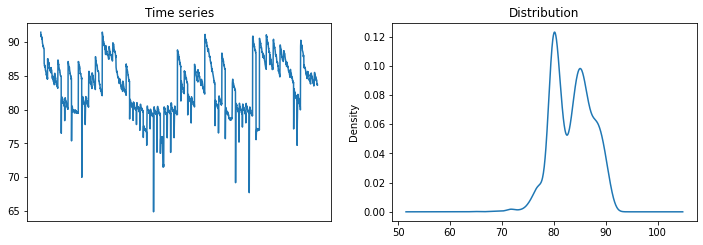

In [174]:
to_analyze(takeoff_data['E1 OilP'])

count    2430.000000
mean      165.207383
std        17.766925
min       129.680000
25%       151.397500
50%       165.190000
75%       181.477500
max       191.590000
Name: E1 OilT, dtype: float64


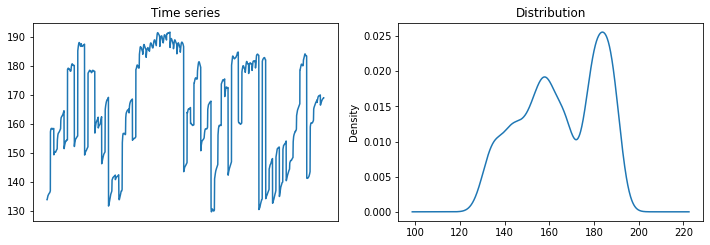

In [178]:
to_analyze(takeoff_data['E1 OilT'])

## Fuel flow

For naturally aspirated engines, fuel flow will be lower with altitude, so you may see a higher distribution.

count    2430.000000
mean       19.374823
std         1.887044
min         6.340000
25%        19.760000
50%        19.890000
75%        19.980000
max        20.320000
Name: E1 FFlow, dtype: float64


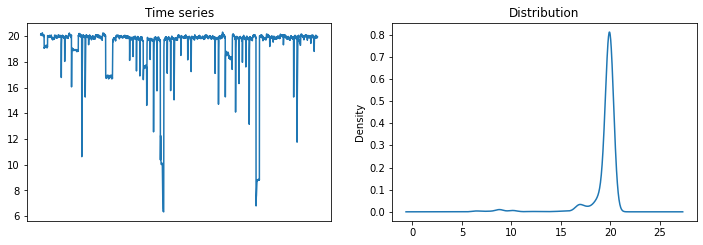

In [175]:
to_analyze(takeoff_data['E1 FFlow'])

## RPM

count    2430.000000
mean     2639.750700
std        45.618612
min      2242.600000
25%      2643.300000
50%      2648.500000
75%      2655.000000
max      2675.700000
Name: E1 RPM, dtype: float64


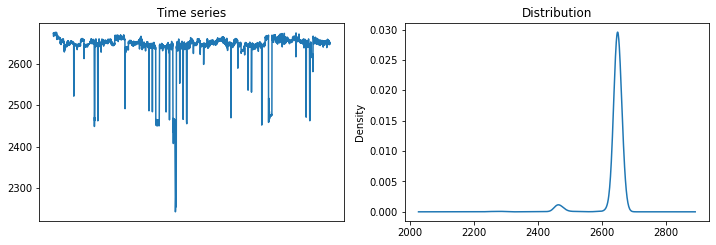

In [176]:
to_analyze(takeoff_data['E1 RPM'])

## EGT

           E1 EGT1      E1 EGT2      E1 EGT3      E1 EGT4
count  2430.000000  2430.000000  2430.000000  2430.000000
mean   1300.113276  1319.138235  1295.605700  1323.870823
std      32.249213    44.609818    37.479967    38.436162
min    1094.370000   970.540000  1024.680000  1061.980000
25%    1289.632500  1310.505000  1287.395000  1313.670000
50%    1307.260000  1331.505000  1303.070000  1331.490000
75%    1315.987500  1342.547500  1311.690000  1342.957500
max    1444.930000  1446.530000  1473.320000  1490.330000


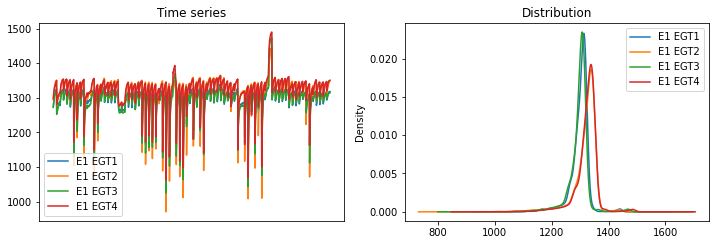

In [177]:
to_analyze(takeoff_data[['E1 EGT1', 'E1 EGT2', 'E1 EGT3', 'E1 EGT4']])